In [1]:
import pyspark.sql.functions as f
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import posexplode
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans as sklearn_kmeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# importing the data
profile = spark.read.json("gs://mbd-project/profile.json")
transcript = spark.read.json("gs://mbd-project/transcript.json")
portfolio = spark.read.json("gs://mbd-project/portfolio.json")

# Data Preparation

## Profile

In [3]:
# check the data types and structure
profile.printSchema()

root
 |-- age: long (nullable = true)
 |-- became_member_on: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- id: string (nullable = true)
 |-- income: long (nullable = true)



Data Explanation 

- age - age of the customer
- became_member_on - date when customer joined the membership
- gender - gender of the customer, Male, Females or Others
- id - customer id
- income - income of the customer


In [4]:
# number of rows
profile.count()

17000

In [5]:
# have a look at the first three rows
profile.head(3)

[Row(age=118, became_member_on='20170212', gender=None, id='68be06ca386d4c31939f3a4f0e3dd783', income=None),
 Row(age=55, became_member_on='20170715', gender='F', id='0610b486422d4921ae7d2bf64640c50b', income=112000),
 Row(age=118, became_member_on='20180712', gender=None, id='38fe809add3b4fcf9315a9694bb96ff5', income=None)]

In [6]:
# some statistics of the data
# maximum age of is 118, possibly error input
profile.describe().show()

+-------+------------------+--------------------+------+--------------------+------------------+
|summary|               age|    became_member_on|gender|                  id|            income|
+-------+------------------+--------------------+------+--------------------+------------------+
|  count|             17000|               17000| 14825|               17000|             14825|
|   mean| 62.53141176470588|2.0167034234117646E7|  null|2.565638242424101E31|  65404.9915682968|
| stddev|26.738579945767256|  11677.499960793006|  null|                null|21598.299410229436|
|    min|                18|            20130729|     F|0009655768c64bdeb...|             30000|
|    max|               118|            20180726|     O|ffff82501cea40309...|            120000|
+-------+------------------+--------------------+------+--------------------+------------------+



In [7]:
# remove the data with age over 100 years old
profile = profile.filter(profile.age <= 99)

In [8]:
# check NA values
profile.select([count(when(col(c).isNull(), c)).alias(c) for c in profile.columns]).show()

+---+----------------+------+---+------+
|age|became_member_on|gender| id|income|
+---+----------------+------+---+------+
|  0|               0|     0|  0|     0|
+---+----------------+------+---+------+



In [9]:
# adjust the data type to dates
profile = profile.withColumn("became_member_on", to_date(col("became_member_on"), "yyyyMMdd"))
# add a now column of the year the customer joined the memebership
profile = profile.withColumn("year", year("became_member_on"))
# profile = profile.withColumn("month", month("became_member_on"))

In [10]:
# profile = profile.withColumn("end_date", to_date(lit("2018-12-31")))
# profile = profile.withColumn("month_diff", round(months_between(col("end_date"), col("became_member_on"))).cast("integer"))
# profile = profile.drop("end_date")

In [11]:
# one-hot encoding year
categ_p = profile.select('year').distinct().rdd.flatMap(lambda x:x).collect()
exprs_p = [when(col('year') == cat, 1).otherwise(0).alias("joined_in_" + str(cat)) 
           for cat in categ_p]
profile = profile.select(exprs_p + profile.columns)

In [12]:
# one-hot encoding gender
categ_p_g = profile.select('gender').distinct().rdd.flatMap(lambda x:x).collect()
exprs_p_g = [when(col('gender') == cat, 1).otherwise(0).alias("gender_" + str(cat)) 
             for cat in categ_p_g]
profile = profile.select(exprs_p_g + profile.columns)

In [13]:
# drop unnecessary columns 
profile = profile.drop("gender", "year", "became_member_on")

In [14]:
# sort the data by customer id
profile = profile.sort("id")

In [15]:
# profile_cleaned = profile.toPandas()
# profile_cleaned.to_csv("profile_cleaned.csv")

In [16]:
# have a look at the first three rows
profile.head(3)

[Row(gender_F=0, gender_M=1, gender_O=0, joined_in_2018=0, joined_in_2015=0, joined_in_2013=0, joined_in_2014=0, joined_in_2016=0, joined_in_2017=1, age=33, id='0009655768c64bdeb2e877511632db8f', income=72000),
 Row(gender_F=0, gender_M=0, gender_O=1, joined_in_2018=1, joined_in_2015=0, joined_in_2013=0, joined_in_2014=0, joined_in_2016=0, joined_in_2017=0, age=40, id='0011e0d4e6b944f998e987f904e8c1e5', income=57000),
 Row(gender_F=1, gender_M=0, gender_O=0, joined_in_2018=0, joined_in_2015=0, joined_in_2013=0, joined_in_2014=0, joined_in_2016=1, joined_in_2017=0, age=59, id='0020c2b971eb4e9188eac86d93036a77', income=90000)]

## Transcript

In [17]:
# check the data types and structure
transcript.printSchema()

root
 |-- event: string (nullable = true)
 |-- person: string (nullable = true)
 |-- time: long (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- amount: double (nullable = true)
 |    |-- offer id: string (nullable = true)
 |    |-- offer_id: string (nullable = true)
 |    |-- reward: long (nullable = true)



Data Explanation

- event - record of offer (offer received, offer viewed, offer completed, transaction)
- person - customer id
- time - time (in hours) since the start of data
- value - transcation value details (stored as a dictionary)
- amount - amount of transaction
- offer id - offer id
- offer_od - offer id
- reward - amount of reward the offer gave


In [18]:
# number of rows
transcript.count()

306534

In [19]:
# have a look at the first three rows
transcript.head(3)

[Row(event='offer received', person='78afa995795e4d85b5d9ceeca43f5fef', time=0, value=Row(amount=None, offer id='9b98b8c7a33c4b65b9aebfe6a799e6d9', offer_id=None, reward=None)),
 Row(event='offer received', person='a03223e636434f42ac4c3df47e8bac43', time=0, value=Row(amount=None, offer id='0b1e1539f2cc45b7b9fa7c272da2e1d7', offer_id=None, reward=None)),
 Row(event='offer received', person='e2127556f4f64592b11af22de27a7932', time=0, value=Row(amount=None, offer id='2906b810c7d4411798c6938adc9daaa5', offer_id=None, reward=None))]

In [20]:
# split the dictionary column
transcript = transcript.select("event", "person", "time", col("value.*"))

In [21]:
# check the data types and structure after spliting
transcript.printSchema()

root
 |-- event: string (nullable = true)
 |-- person: string (nullable = true)
 |-- time: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- offer id: string (nullable = true)
 |-- offer_id: string (nullable = true)
 |-- reward: long (nullable = true)



In [22]:
# check NA data
transcript.select([count(when(col(c).isNull(), c)).alias(c) for c in transcript.columns]).show()

+-----+------+----+------+--------+--------+------+
|event|person|time|amount|offer id|offer_id|reward|
+-----+------+----+------+--------+--------+------+
|    0|     0|   0|167581|  172532|  272955|272955|
+-----+------+----+------+--------+--------+------+



In [23]:
# combine the values in offer id and offer_id together
transcript = transcript.withColumn("offer", 
                                   when(transcript.offer_id.isNull(), col("offer id"))
                                   .otherwise(col("offer_id")))

In [24]:
# check NA data
transcript.select([count(when(col(c).isNull(), c)).alias(c) for c in transcript.columns]).show()

+-----+------+----+------+--------+--------+------+------+
|event|person|time|amount|offer id|offer_id|reward| offer|
+-----+------+----+------+--------+--------+------+------+
|    0|     0|   0|167581|  172532|  272955|272955|138953|
+-----+------+----+------+--------+--------+------+------+



In [25]:
# only keep necessary columns
transcript = transcript.select("event", "person", "time", "amount", "reward", "offer")

In [26]:
# change the column name
transcript = transcript.withColumnRenamed("offer", "offer_id")

In [27]:
# one-hot encoding event
categ_event = transcript.select('event').distinct().rdd.flatMap(lambda x:x).collect()
exprs_event = [when(col('event') == cat, 1).otherwise(0).alias(str(cat)) 
               for cat in categ_event]
transcript = transcript.select(exprs_event + transcript.columns)

In [28]:
#transcript = transcript.drop("event")

In [29]:
# rename the rows generated from one-hot enconding
transcript = transcript.withColumnRenamed("offer received", "offer_received") \
.withColumnRenamed("offer completed", "offer_completed") \
.withColumnRenamed("offer viewed", "offer_viewed")

In [30]:
# transcript = transcript.withColumn("day", round(transcript.time / 24).cast('integer'))
# transcript = transcript.drop("time")

In [31]:
# sort the data based on the customer id and the time receiving the offer
transcript = transcript.sort("person", "time")

In [32]:
# transcript_cleaned = transcript.toPandas()
# transcript_cleaned.to_csv("transcript_cleaned.csv")

In [33]:
# have a look at the first three rows
transcript.head(3)

[Row(transaction=0, offer_received=1, offer_completed=0, offer_viewed=0, event='offer received', person='0009655768c64bdeb2e877511632db8f', time=168, amount=None, reward=None, offer_id='5a8bc65990b245e5a138643cd4eb9837'),
 Row(transaction=0, offer_received=0, offer_completed=0, offer_viewed=1, event='offer viewed', person='0009655768c64bdeb2e877511632db8f', time=192, amount=None, reward=None, offer_id='5a8bc65990b245e5a138643cd4eb9837'),
 Row(transaction=1, offer_received=0, offer_completed=0, offer_viewed=0, event='transaction', person='0009655768c64bdeb2e877511632db8f', time=228, amount=22.16, reward=None, offer_id=None)]

## Portfolio

In [34]:
# check the data types and structure
portfolio.printSchema()

root
 |-- channels: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- difficulty: long (nullable = true)
 |-- duration: double (nullable = true)
 |-- id: string (nullable = true)
 |-- offer_type: string (nullable = true)
 |-- reward: long (nullable = true)



Data Explanation

- channels - channel used to distribute offers (stored as a list)
- difficulty - difficulty spent to complete an offer
- duration - time (in hours) that the offer is valid
- id - offer id
- offer_type - type of the offer (buy one get one, discount, information)
- reward - reward given for completing an offer


In [35]:
# adjust the data type of duration to integer
portfolio = portfolio.withColumn("duration", col("duration").cast('integer'))

In [36]:
# split the list of channels
portfolio = portfolio.select("difficulty", "duration", "id", "offer_type", "reward", 
                             posexplode("channels"))

In [37]:
# one-hot encoding channels
categ_channel = portfolio.select('col').distinct().rdd.flatMap(lambda x:x).collect()
exprs_channel = [when(col('col') == cat, 1).otherwise(0).alias("channel_" + str(cat)) 
                 for cat in categ_channel]
portfolio = portfolio.select(exprs_channel + portfolio.columns)

In [38]:
# adjust the one-hot encoding results
channels = portfolio.groupBy("id").sum("channel_mobile", "channel_email",
                                       "channel_social", "channel_web")
portfolio = portfolio.join(channels, ['id'])
portfolio = portfolio.drop("channel_mobile", "channel_email", "channel_social", "channel_web")
# rename the columns
portfolio = portfolio.withColumnRenamed("sum(channel_mobile)", "channel_mobile") \
.withColumnRenamed("sum(channel_email)", "channel_email")\
.withColumnRenamed("sum(channel_social)", "channel_social")\
.withColumnRenamed("sum(channel_web)", "channel_web")
# drop unneccesary columns 
portfolio = portfolio.drop("pos", "col").distinct()

In [39]:
# one-hot encoding offer types
categ_offer = portfolio.select('offer_type').distinct().rdd.flatMap(lambda x:x).collect()
exprs_offer = [when(col('offer_type') == cat, 1).otherwise(0).alias(str(cat)) 
               for cat in categ_offer]
portfolio = portfolio.select(exprs_offer + portfolio.columns)

In [40]:
# portfolio = portfolio.drop("offer_type")

In [41]:
# portfolio_cleaned = portfolio.toPandas()
# portfolio_cleaned.to_csv("portfolio_cleaned.csv")

In [42]:
# have a look at the first three rows
portfolio.head(3)

[Row(discount=0, informational=0, bogo=1, id='f19421c1d4aa40978ebb69ca19b0e20d', difficulty=5, duration=5, offer_type='bogo', reward=5, channel_mobile=1, channel_email=1, channel_social=1, channel_web=1),
 Row(discount=0, informational=0, bogo=1, id='ae264e3637204a6fb9bb56bc8210ddfd', difficulty=10, duration=7, offer_type='bogo', reward=10, channel_mobile=1, channel_email=1, channel_social=1, channel_web=0),
 Row(discount=0, informational=0, bogo=1, id='4d5c57ea9a6940dd891ad53e9dbe8da0', difficulty=10, duration=5, offer_type='bogo', reward=10, channel_mobile=1, channel_email=1, channel_social=1, channel_web=1)]

# Joining Tables

In [43]:
# filter the transcripts that customers made transactions
# some transactions are made with offers, some are not
transactions = transcript.filter(transcript.event == "transaction")
transactions = transactions.select("person", "event", "time", "amount")

In [44]:
# join the transactions with customer profiles
transactions = transactions.join(profile, transactions.person == profile.id, "left")
transactions = transactions.drop("event", "id")

In [45]:
# filter the transcripts that record different steps of offers
offers = transcript.filter(transcript.event != "transaction")
offers = offers.select("person", "offer_id", "event",
                       "time", "offer_received", "offer_viewed", "offer_completed")

In [46]:
# join the three tables
offers = offers.join(profile, offers.person == profile.id, "left")
offers = offers.join(portfolio, offers.offer_id == portfolio.id, "left")
offers = offers.drop("id")

In [47]:
# drop NAs
offers = offers.dropna()

In [48]:
#transactions = transactions.dropna()

# Feature Engineering

## Drop duplicated offers

In [49]:
# adding columns of the received time, viewed time, and completed time
# because time starts with 0, the time all plus 1 hours to make columns
offers = offers.withColumn("time", col("time") + 1)
offers = offers.withColumn("time_received", col("offer_received") * col("time")) \
.withColumn("time_viewed", col("offer_viewed") * col("time")) \
.withColumn("time_completed", col("offer_completed") * col("time"))

In [50]:
# drop duplicated offers
# because one person can receive receive or see the offer multiple times
# only keep the first time the customer received and view the offer
offers_first_time = offers.groupBy("person", "offer_id", "offer_type", "event").min()
# also store the total number of times the customer received and view the offer 
offers_all_time = offers.groupBy("person", "offer_id", "offer_type", "event") \
.sum('offer_received', 'offer_viewed', 'offer_completed')
# join above two tables together
offers_first_time = offers_first_time.alias("a").join(offers_all_time.alias("b"), \
                (offers_first_time.person == offers_all_time.person) & \
                (offers_first_time.offer_id == offers_all_time.offer_id) & \
                (offers_first_time.event == offers_all_time.event)) \
                .select("a.*", 
                        "b.sum(offer_received)", "b.sum(offer_viewed)", "b.sum(offer_completed)")

In [51]:
# because we have stored the time the offer was received, viewed, and completed
# we can only keep one row of each customer
# using maximum value to keep the last step of the offer
offers_data = offers_first_time.groupBy("person", "offer_id", "offer_type").max()
offers_data = offers_data.drop("max(min(offer_received))",
                               "max(min(offer_viewed))",
                               "max(min(offer_completed))")

In [52]:
# adjust the column names
new_names = ['person', 'offer_id', 'offer_type', 'time', 
             'gender_F', 'gender_M', 'gender_O', 
             'joined_in_2018', 'joined_in_2015', 'joined_in_2013', 
             'joined_in_2014', 'joined_in_2016', 'joined_in_2017', 
             'age', 'income', 'discount', 'informational', 'bogo', 'difficulty',
             'duration', 'reward', 
             'channel_mobile', 'channel_email', 'channel_social', 'channel_web',
             'time_received', 'time_viewed', 'time_completed',
             'offer_received', 'offer_viewed', 'offer_completed']
offers_data = offers_data.toDF(*new_names)

In [53]:
# filter the data
# if the customer didn't view the offer, but completed the offer
# if the customer completed the offer, but the completed before viewing the offer
offers_data = offers_data \
.filter(~((col("time_completed") > 0) & (col("time_viewed") == 0))) \
.filter(~((col("time_completed") != 0) & (col("time_completed") < col("time_viewed"))))

## Transactions amount and frequency

In [54]:
# calculate the amount customer paid per visit, and the frequency of visiting
transactions = transactions.groupBy("person").agg(avg("amount").alias("amount_per_visit"), \
                                                  count("time").alias("frequency"))

In [55]:
# join the profile table and transactions table together
customers = profile.join(transactions, profile.id == transactions.person, "left")
customers = customers.drop("id")

## Conversion rate of different types of offers

In [56]:
# filter different types of offers
bogo_offers = offers_data.filter(col("offer_type") == "bogo")
discount_offers = offers_data.filter(col("offer_type") == "discount")
informational_offers = offers_data.filter(col("offer_type") == "informational")
# filter offers that are not informational, the offers giving rewards
non_info_offers = offers_data.filter(col("offer_type") != "informational")

In [57]:
# as long as the customers receive the offer, no matter how many times, count as 1
# otherwise 0
# same as view or complete the offers
bogo_offers = bogo_offers \
    .withColumn("offers_received_cnt", when(col("offer_received") > 0, 1).otherwise(0)) \
    .withColumn("offers_viewed_cnt", when(col("offer_viewed") > 0, 1).otherwise(0)) \
    .withColumn("offers_completed_cnt", when(col("offer_completed") > 0, 1).otherwise(0))
discount_offers = discount_offers \
    .withColumn("offers_received_cnt", when(col("offer_received") > 0, 1).otherwise(0)) \
    .withColumn("offers_viewed_cnt", when(col("offer_viewed") > 0, 1).otherwise(0)) \
    .withColumn("offers_completed_cnt", when(col("offer_completed") > 0, 1).otherwise(0))
informational_offers = informational_offers \
    .withColumn("offers_received_cnt", when(col("offer_received") > 0, 1).otherwise(0)) \
    .withColumn("offers_viewed_cnt", when(col("offer_viewed") > 0, 1).otherwise(0)) \
    .withColumn("offers_completed_cnt", when(col("offer_completed") > 0, 1).otherwise(0))
non_info_offers = non_info_offers \
    .withColumn("offers_received_cnt", when(col("offer_received") > 0, 1).otherwise(0)) \
    .withColumn("offers_viewed_cnt", when(col("offer_viewed") > 0, 1).otherwise(0)) \
    .withColumn("offers_completed_cnt", when(col("offer_completed") > 0, 1).otherwise(0))

In [58]:
# how many times the customer receive, view, complete the offers
bogo_cnt = bogo_offers.groupBy("person") \
    .sum("offers_received_cnt", "offers_viewed_cnt", "offers_completed_cnt")
discount_cnt = discount_offers.groupBy("person") \
    .sum("offers_received_cnt", "offers_viewed_cnt", "offers_completed_cnt")
informational_cnt = informational_offers.groupBy("person") \
    .sum("offers_received_cnt", "offers_viewed_cnt", "offers_completed_cnt")
non_info_cnt = non_info_offers.groupBy("person") \
    .sum("offers_received_cnt", "offers_viewed_cnt", "offers_completed_cnt")

In [59]:
# conversion rate from receive to view
# conversion rate from view to complete
bogo_offers = bogo_cnt \
    .withColumn("bogo_view_rate", col("sum(offers_viewed_cnt)") / col("sum(offers_received_cnt)")) \
    .withColumn("bogo_complete_rate", col("sum(offers_completed_cnt)") / col("sum(offers_viewed_cnt)"))
discount_offers = discount_cnt \
    .withColumn("discount_view_rate", col("sum(offers_viewed_cnt)") / col("sum(offers_received_cnt)")) \
    .withColumn("discount_complete_rate", col("sum(offers_completed_cnt)") / col("sum(offers_viewed_cnt)"))
informational_offers = informational_cnt \
    .withColumn("informational_view_rate", col("sum(offers_viewed_cnt)") / col("sum(offers_received_cnt)"))
non_info_offers = non_info_cnt \
    .withColumn("non_info_view_rate", col("sum(offers_completed_cnt)") / col("sum(offers_viewed_cnt)")) \
    .withColumn("non_info_complete_rate", col("sum(offers_completed_cnt)") / col("sum(offers_viewed_cnt)"))

In [60]:
# drop unnecessary columns
bogo_offers = bogo_offers.drop("sum(offers_received_cnt)", "sum(offers_viewed_cnt)", 
                               "sum(offers_completed_cnt)")
discount_offers = discount_offers.drop("sum(offers_received_cnt)", "sum(offers_viewed_cnt)",
                                       "sum(offers_completed_cnt)")
informational_offers = informational_offers.drop("sum(offers_received_cnt)", "sum(offers_viewed_cnt)", 
                                                 "sum(offers_completed_cnt)")
non_info_offers = non_info_offers.drop("sum(offers_received_cnt)", "sum(offers_viewed_cnt)",
                                       "sum(offers_completed_cnt)")

In [61]:
# join profiles, transactions, and offers data together
customers = customers.join(bogo_offers, "person", "left") \
.join(discount_offers, "person", "left") \
.join(informational_offers, "person", "left") \
.join(non_info_offers, "person", "left")
customers = customers.fillna(0)

## Aggregated offer data per customer

In [62]:
# other aggregated data per customer
customers_data = offers_data.groupBy("person") \
    .agg(avg("reward").alias("reward_avg"), \
         avg("difficulty").alias("difficulty_avg"), \
         sum("channel_email").alias("email_cnt"), \
         sum("channel_mobile").alias("mobile_cnt"), \
         sum("channel_social").alias("social_cnt"), \
         sum("channel_web").alias("web_cnt"), \
         sum("bogo").alias("total_bogo_received"), \
         sum("discount").alias("total_discount_received"), \
         sum("informational").alias("total_informational_received"),
         # calculate the average times the customer receive, view or complete per offer
         # given that the customer can receive, view or complete offers multiple times
         avg("offer_received").alias("received_per_offer"), \
         avg("offer_viewed").alias("viewed_per_offer"), \
         avg("offer_completed").alias("completed_per_offer")) 

In [63]:
# calculate the total offers the customer receive, view or complete
all_offers = offers_data
all_offers = all_offers \
    .withColumn("total_offers_received", when(col("offer_received") > 0, 1).otherwise(0)) \
    .withColumn("total_offers_viewed", when(col("offer_viewed") > 0, 1).otherwise(0)) \
    .withColumn("total_offers_completed", when(col("offer_completed") > 0, 1).otherwise(0))
all_cnt = all_offers.groupBy("person") \
    .sum("total_offers_received", "total_offers_viewed", "total_offers_completed")

In [64]:
customers_data = customers_data.join(all_cnt, "person")

# Join the tables together

In [65]:
# join the tables together and drop duplicates
starbucks = customers.join(customers_data, "person")
starbucks = starbucks.dropna()

In [66]:
starbucks = starbucks \
.withColumnRenamed("sum(total_offers_received)", "total_offers_received") \
.withColumnRenamed("sum(total_offers_viewed)", "total_offers_viewed") \
.withColumnRenamed("sum(total_offers_completed)", "total_offers_completed")

# Clustering Analysis

In [67]:
# caculate the variable means
# necessary because StandardScaler in pyspark is different from the one in sklearn
starbucks = starbucks.union(starbucks.select(*[avg(c).alias(c) for c in starbucks.columns]))

## Vectorization

In [68]:
# needed for pyspark modeling
assembler = VectorAssembler(inputCols=starbucks.columns[1:], outputCol='features')
starbucks_assembled = assembler.transform(starbucks)

## Standardization

In [69]:
# ignore the warning message
spark.conf.set("spark.sql.debug.maxToStringFields", 100)
scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='standardized')
starbucks_scaled = scaler.fit(starbucks_assembled).transform(starbucks_assembled)

## Dimensionality reduction

In [72]:
# first using all variables to find the explained varience of each variable
pca = PCA(k=34, inputCol="standardized", outputCol="pcaFeatures")
pca_model = pca.fit(starbucks_scaled)

In [73]:
# number of variables that explains 80% variance
k = np.sum(np.cumsum(pca_model.explainedVariance) < 0.8)
k

11

In [74]:
# pca using number of variables that explains 80% variance
pca = PCA(k=k, inputCol="standardized", outputCol="pcaFeatures")
pca_model = pca.fit(starbucks_scaled)
starbucks_pca = pca_model.transform(starbucks_scaled)

## Clustering

### Calculating silhouette scores

In [75]:
# convert to pandas to calculate the silhouette scores and find optimal k
def extract(row):
    return (row.person, ) + tuple(row.pcaFeatures.toArray().tolist())
starbucks_pd = starbucks_pca.select("person", "pcaFeatures") \
.rdd.map(extract).toDF(["person"]).toPandas() 

In [76]:
# calculating silhouette scores using different numbers of clusters
silhouettes = []
for n_clusters in range(3, 11, 1):
    clusterer = sklearn_kmeans(n_clusters=n_clusters, random_state=6)
    cluster_labels = clusterer.fit_predict(starbucks_pd.iloc[:,1:])
    silhouette_avg = silhouette_score(starbucks_pd.iloc[:,1:], cluster_labels)
    silhouettes.append(silhouette_avg)

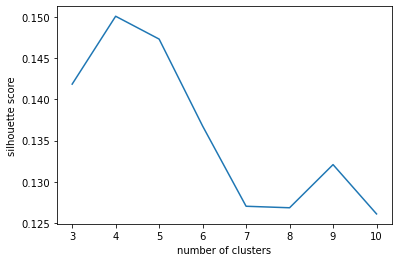

In [77]:
# plot the result
# the optimal option is to use 4 clusters
import warnings
warnings.filterwarnings("ignore")

sns.lineplot(range(3, 11, 1), silhouettes)
plt.xlabel("number of clusters")
plt.ylabel("silhouette score");

### Clustering using PySpark

In [79]:
# continue using PySpark outputs
# not the pandas output, the pandas output is just used for finding k
kmeans = KMeans().setK(4).setSeed(1).setFeaturesCol('pcaFeatures')
starbucks_clustered = kmeans.fit(starbucks_pca).transform(starbucks_pca)

In [80]:
# drop unnecessary columns
starbucks_clustered = starbucks_clustered.drop("features", "standardized", "pcaFeatures")

In [81]:
# convert the clustering result to pandas
starbucks_clustered_pd = starbucks_clustered.toPandas()

In [82]:
# melt the dataframe
clusters_data = starbucks_clustered_pd.melt(id_vars=['person', 'prediction']) \
.groupby(['prediction', 'variable']).mean().reset_index()

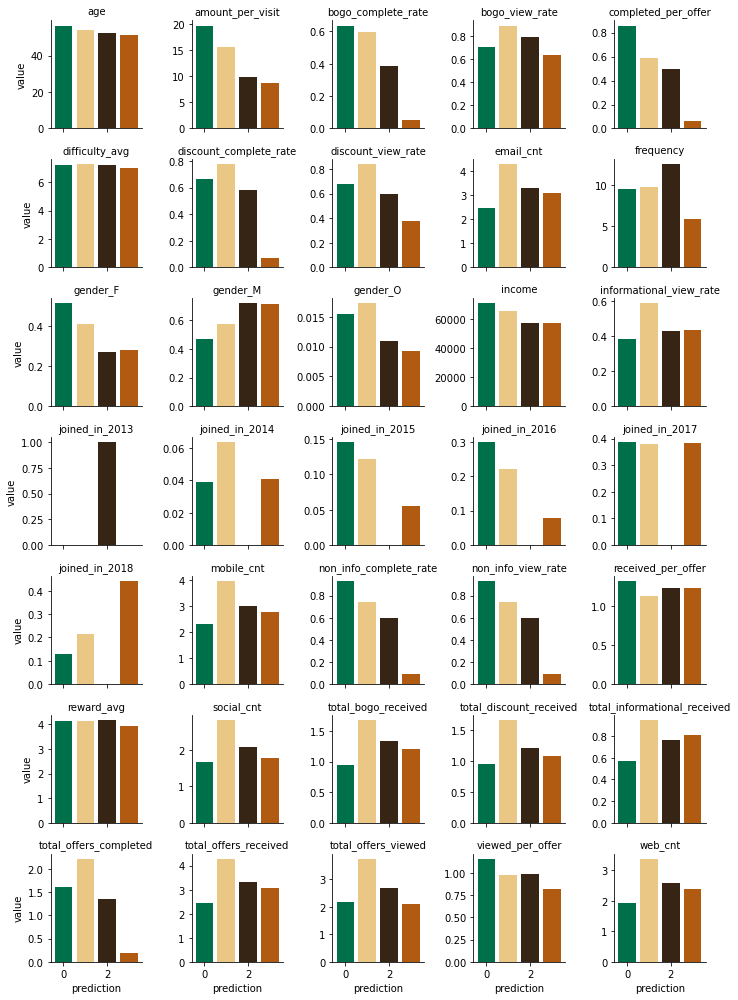

In [88]:
# plotting the clusters
cluster_plots = sns.FacetGrid(clusters_data, col='variable', hue='prediction', 
                              palette=["#00704A", "#eac784", "#362415", "#b15a11"],
                              col_wrap=5, height=2, sharey=False)
cluster_plots = cluster_plots.map(plt.bar, 'prediction', 'value').set_titles("{col_name}");

In [90]:
starbucks_clustered_pd.to_csv("starbucks_clustered.csv")